# Fetching data from a CSW catalog with Python tools

This notebook shows a typical workflow to query a [Catalog Service for the Web (CSW)](https://en.wikipedia.org/wiki/Catalog_Service_for_the_Web) and create a request for data endpoints that are suitable for download.

In this queries multiple catalogs for the near real time HF-Radar current data.

In [1]:
import os
import sys

ioos_tools = os.path.join(os.path.pardir)
sys.path.append(ioos_tools)

The first step is to create the data filter based on the geographical region bounding box, the time span, and the CF variable standard name.

In [2]:
from datetime import datetime, timedelta

# Region: West coast.
min_lon, max_lon = -123, -121
min_lat, max_lat = 36, 40

bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

# Temporal range: Last week.
now = datetime.utcnow()
start, stop = now - timedelta(days=(7)), now

# Surface velocity CF names.
cf_names = ['surface_northward_sea_water_velocity',
            'surface_eastward_sea_water_velocity']

Now it is possible to assemble a [OGC Filter Encoding (FE)](http://www.opengeospatial.org/standards/filter) for the search using `owslib.fes`\*. Note that the final result is only a list with all the filtering conditions.

\* OWSLib is a Python package for client programming with Open Geospatial Consortium (OGC) web service (hence OWS) interface standards, and their related content models.

In [3]:
from owslib import fes
from ioos_tools.ioos import fes_date_filter

kw = dict(wildCard='*', escapeChar='\\',
          singleChar='?', propertyname='apiso:AnyText')

or_filt = fes.Or([fes.PropertyIsLike(literal=('*%s*' % val), **kw)
                  for val in cf_names])

# Exclude GNOME returns.
not_filt = fes.Not([fes.PropertyIsLike(literal='*GNOME*', **kw)])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)
filter_list = [fes.And([bbox_crs, begin, end, or_filt, not_filt])]

It is possible to use the same filter to search multiple catalogs. The cell below loops over 3 catalogs hoping to find which one is more up-to-date and returns the near real time data.

In [4]:
from owslib.csw import CatalogueServiceWeb


catalogs = [
    #'https://dev-catalog.ioos.us/csw',
    'http://www.ngdc.noaa.gov/geoportal/csw',
    'http://geoport.whoi.edu/csw'
]

for endpoint in catalogs:
    csw = CatalogueServiceWeb(endpoint, timeout=60)
    csw.getrecords2(constraints=filter_list, maxrecords=1000, esn='full')
    records = '\n'.join(csw.records.keys())
    if records:
        print('{}\n{}\n'.format(endpoint, records))

No HF-Radar data was found there!
Those catalogs are probably outdated since it is known that the data exists.
One trick is to confirm that is to remove the time constraint.

In [5]:
filter_list = [fes.And([bbox_crs, or_filt, not_filt])]


for endpoint in catalogs:
    csw = CatalogueServiceWeb(endpoint, timeout=60)
    csw.getrecords2(constraints=filter_list, maxrecords=1000, esn='full')
    records = '\n'.join(csw.records.keys())
    if records:
        print('{}\n{}\n'.format(endpoint, records))

http://www.ngdc.noaa.gov/geoportal/csw
HFRNet/USWC/500m/hourly/RTV
HFRNet/USWC/1km/hourly/RTV
HFRNet/USWC/2km/hourly/RTV
HFRNet/USWC/6km/hourly/RTV
HFR/USWC/1km/hourly/RTV/HFRADAR,_US_West_Coast,_1km_Resolution,_Hourly_RTV_best.ncd
HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd



The `NGCD` catalog returned some endpoints,
but there is no way to know if they are updated with the latest data unless we inspect them.

The cells below create a new `CatalogueServiceWeb` `csw` object,
only for the NGDC catalog now, and inspect the records available.

In [6]:
csw = CatalogueServiceWeb(catalogs[0], timeout=60)
csw

In [7]:
csw.getrecords2(constraints=filter_list, maxrecords=1000, esn='full')

In [8]:
print('Found {} records.\n'.format(len(csw.records.keys())))
for key, value in list(csw.records.items()):
    print('[{}]: {}'.format(value.title, key))

Found 6 records.

[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
500 m Resolution]: HFRNet/USWC/500m/hourly/RTV
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
1 km Resolution]: HFRNet/USWC/1km/hourly/RTV
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
2 km Resolution]: HFRNet/USWC/2km/hourly/RTV
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
6 km Resolution]: HFRNet/USWC/6km/hourly/RTV
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
1 km Resolution]: HFR/USWC/1km/hourly/RTV/HFRADAR,_US_West_Coast,_1km_Resolution,_Hourly_RTV_best.ncd
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
2 km Resolution]: HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd


In [9]:
print(value.abstract)

Surface ocean velocities estimated from HF-Radar are
representative of the upper 0.3 - 2.5 meters of the
ocean.  The main objective of near-real time
processing is to produce the best product from
available data at the time of processing.  Radial
velocity measurements are obtained from individual
radar sites through the U.S. HF-Radar Network.
Hourly radial data are processed by unweighted
least-squares on a 2 km resolution grid of the U.S.
West Coast to produce near real-time surface current
maps.


Based on the record titles and abstract it seems that there is near real time data available.

The next step is to inspect the type services/schemes available for downloading the data. The easiest way to accomplish that is with by "sniffing" the URLs with `geolinks`.

In [10]:
from geolinks import sniff_link

msg = 'geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n'.format
for ref in value.references:
    print(msg(geolink=sniff_link(ref['url']), **ref))

geolink: WWW:LINK
scheme: urn:x-esri:specification:ServiceType:distribution:url
URL: http://hfrnet.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd.html

geolink: None
scheme: urn:x-esri:specification:ServiceType:distribution:url
URL: http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://hfrnet.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd

geolink: OGC:WMS
scheme: urn:x-esri:specification:ServiceType:wms:url
URL: http://hfrnet.ucsd.edu/thredds/wms/HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd?service=WMS&version=1.3.0&request=GetCapabilities

geolink: OGC:WCS
scheme: urn:x-esri:specification:ServiceType:wcs:url
URL: http://hfrnet.ucsd.edu/thredds/wcs/HFR/USWC/2km/hourly/RTV/HFRADAR,_US_West_Coast,_2km_Resolution,_Hourly_RTV_best.ncd?service=WCS&version=1.0.0&request=GetCapabilities

geolink: None
scheme: urn:x-esri:s

There are links

For a detailed description of what those `geolink` results mean check the [lookup](https://github.com/OSGeo/Cat-Interop/blob/master/LinkPropertyLookupTable.csv) table.
There are Web Coverage Service (WCS), Web Map Service (WMS),
direct links, and OPeNDAP (identified as `None` !?) services available.

The easiest one to explore is the open OPeNDAP endpoint.
The next 5 cells downloads and plot the current data for the day before,
to check if the endpoint is indeed near real time.

In [11]:
import xarray as xr

url = value.references[4]['url']

ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:       (lat: 1099, lon: 700, nProcParam: 7, nSites: 49, time: 45084)
Coordinates:
  * lat           (lat) float32 30.25 30.268 30.286 30.3039 30.3219 30.3399 ...
  * lon           (lon) float32 -130.36 -130.339 -130.318 -130.298 -130.277 ...
  * time          (time) datetime64[ns] 2011-10-01 2011-10-01T01:00:00 ...
    time_run      (time) datetime64[ns] ...
  * nSites        (nSites) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * nProcParam    (nProcParam) int64 0 1 2 3 4 5 6
Data variables:
    site_lat      (nSites) float32 ...
    site_lon      (nSites) float32 ...
    site_code     (nSites) |S64 ...
    site_netCode  (nSites) |S64 ...
    procParams    (nProcParam) float32 ...
    time_offset   (time) datetime64[ns] ...
    u             (time, lat, lon) float32 ...
    v             (time, lat, lon) float32 ...
    DOPx          (time, lat, lon) float32 ...
    DOPy          (time, lat, lon) float32 ...
Attributes:
    netcdf_library_version

Select "yesterday" data.

In [12]:
from datetime import date, timedelta

yesterday = date.today() - timedelta(days=1)

ds = ds.sel(time=yesterday)

Compute the speed while masking invalid values.

In [13]:
import numpy.ma as ma

u = ds['u'].data
v = ds['v'].data

lon = ds.coords['lon'].data
lat = ds.coords['lat'].data
time = ds.coords['time'].data

u = ma.masked_invalid(u)
v = ma.masked_invalid(v)

This cell is only a trick to show all quiver arrows with the same length,
for visualization purposes,
and indicate the vector magnitude with colors instead.

In [14]:
import numpy as np
from oceans import uv2spdir, spdir2uv

angle, speed = uv2spdir(u, v)
us, vs = spdir2uv(np.ones_like(speed), angle, deg=True)

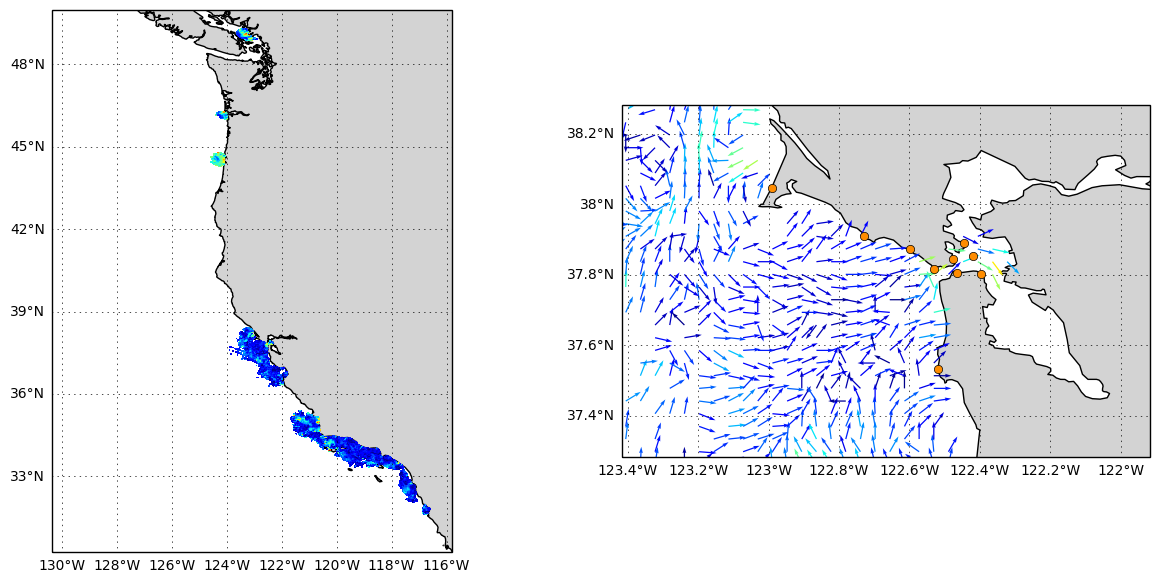

In [15]:
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cartopy import feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

LAND = feature.NaturalEarthFeature('physical', 'land', '10m',
                                   edgecolor='face',
                                   facecolor='lightgray')

sub = 2
dx = dy = 0.5
center = -122.416667, 37.783333  # San Francisco.
bbox = lon.min(), lon.max(), lat.min(), lat.max()

fig, (ax0, ax1) = plt.subplots(
    ncols=2,
    figsize=(15, 7),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)


ax0.set_extent(bbox)
ax0.pcolormesh(lon, lat, ma.masked_invalid(speed))
gl = ax0.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax0.add_feature(LAND, zorder=0, edgecolor='black')


ax1.set_extent([center[0]-dx-dx, center[0]+dx, center[1]-dy, center[1]+dy])
ax1.quiver(lon[::sub], lat[::sub],
           us[::sub, ::sub], vs[::sub, ::sub],
           speed[::sub, ::sub], scale=30)
gl = ax1.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(LAND, zorder=0, edgecolor='black')
ax1.plot(ds['site_lon'], ds['site_lat'], marker='o', linestyle='none', color='darkorange')

And here is yesterday's sea surface currents from the west coast with a zoom in the bay area.


<br>
Right click and choose Save link as... to
[download](https://raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2016-11-20-finding_HFRadar_currents.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/urls/raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2016-11-20-finding_HFRadar_currents.ipynb).